In [3]:
# basic plotting imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # high res plotting

import numpy as np

from neurodsp.sim import sim_synaptic_current
from neurodsp.spectral import compute_spectrum
from neurodsp.filt import filter_signal
from neurodsp.timefrequency import phase_by_time

from fooof import FOOOF

from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns


/var/folders/_x/fjk_0tsx1sl4yvjz3z1xq7540000gn/T/ipykernel_13746/1631596146.py:12: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [46]:
def phase_phase_coherence(signal1, signal2, fs, filter_range, n_seconds_filter):
    """
    Estimate the phase-phase coherence between two time series.

    Parameters:
    signal1 : numpy.ndarray
        First time series.
    signal2 : numpy.ndarray
        Second time series.
    fs : int
        Sampling rate of the signals.
    filter_range : tuple
        Frequency range for filtering the signals.
    n_seconds_filter : float
        Number of seconds to use for filtering.

    Returns:
    coherence : float
        Phase-phase coherence between the two signals.
    """
    # Compute phase of the signals
    phase1 = phase_by_time(signal1, fs, filter_range, n_seconds=n_seconds_filter)
    phase2 = phase_by_time(signal2, fs, filter_range, n_seconds=n_seconds_filter)

    # Remove NaNs
    phase1 = phase1[~np.isnan(phase1)]
    phase2 = phase2[~np.isnan(phase2)]

    # Compute phase difference
    phase_diff = phase1 - phase2

    # Compute phase coherence
    coherence = np.abs(np.mean(np.exp(1j * phase_diff)))

    return coherence


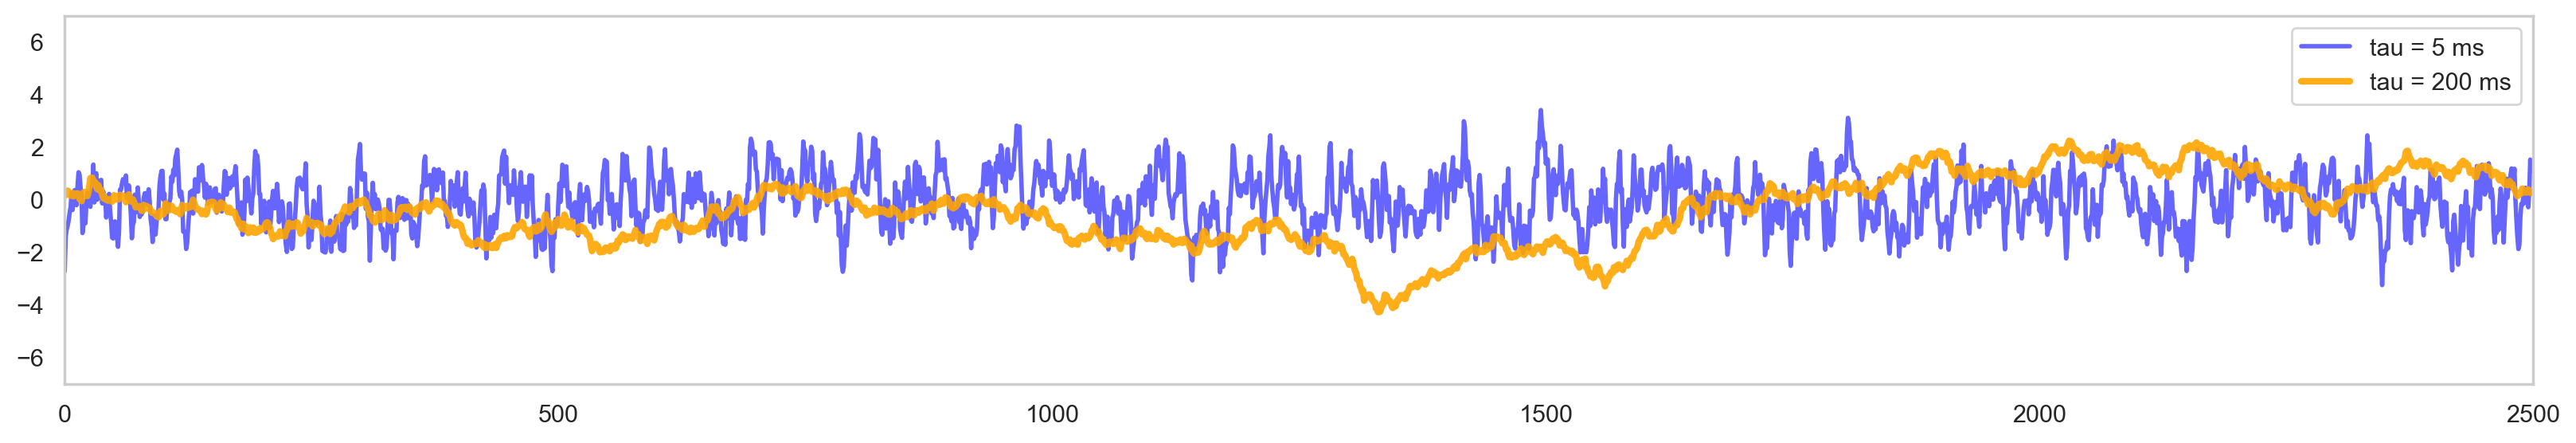

In [21]:
# simulate aperiodic signals driven solely by a single postsynaptic current
n_seconds = 5*60 # 5-minutes of resting state
fs = 1000 # sampling rate

# fast timescale, low autocorrelation
tau = 0.005 # kernal tau, in seconds
sim_signalA = sim_synaptic_current(n_seconds, fs, tau_d=tau)

# slow timescale, high autocorrelation
tau = 0.200 # kernal tau, in seconds
sim_signalB = sim_synaptic_current(n_seconds, fs, tau_d=tau)

sns.set_theme(rc={'figure.figsize':(20,3)})
sns.set_style('whitegrid')
sns.set_style("whitegrid", {'axes.grid' : False})
plt.plot(sim_signalA, color='blue', alpha=0.6, linewidth=2, label='tau = 5 ms')
plt.plot(sim_signalB, color='orange', alpha=0.9, linewidth=3, label='tau = 200 ms')
plt.xlim(0, fs*2.5)
plt.ylim(-7, 7)
plt.legend()
plt.show()



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

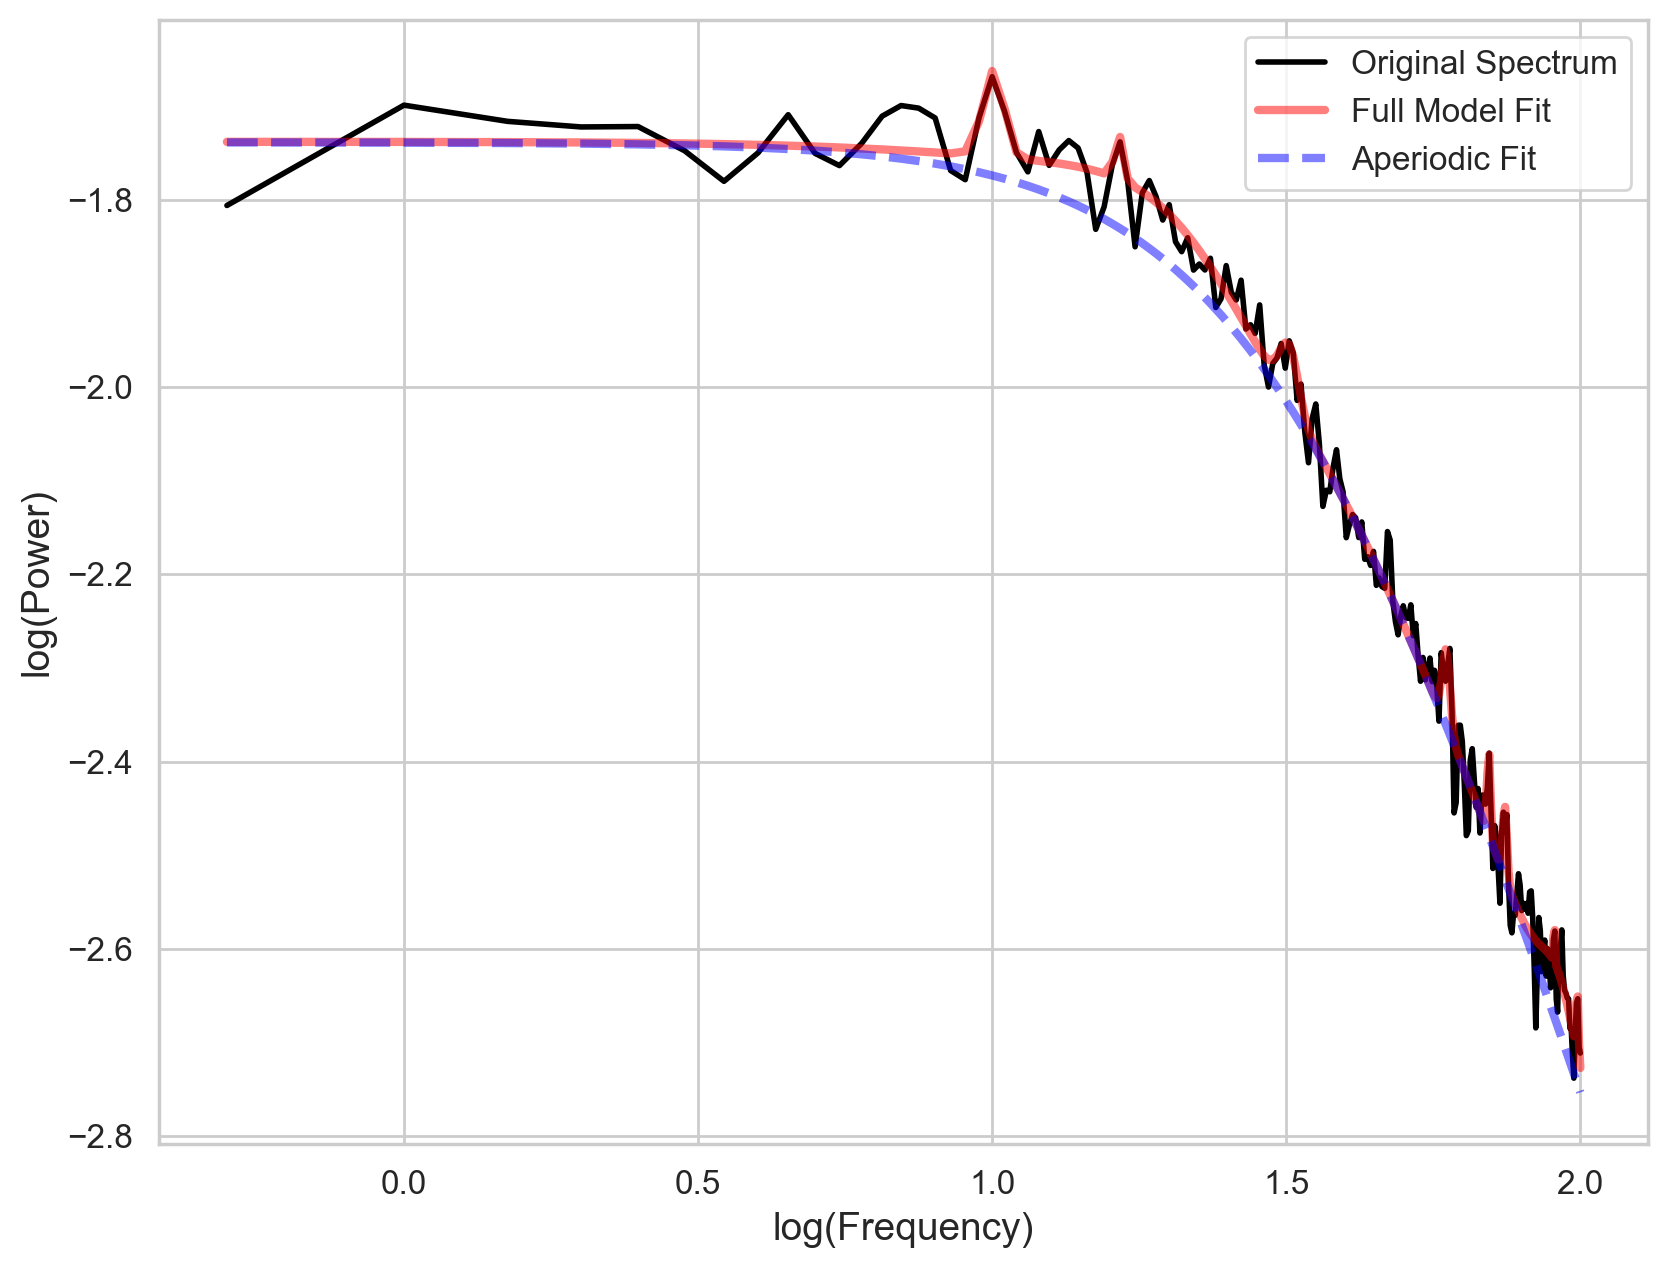

In [23]:
# get the PSD of the simulated signal
freqs, spectrum = compute_spectrum(sim_signalA, fs, method='welch', avg_type='mean', nperseg=fs*2)

# frequency range to fit the spectral model
freq_range = [0.1, 100]

# initialize
max_n_peaks = 10 # overfit peaks on purpose to get better aperiodic fit
fm = FOOOF(max_n_peaks=max_n_peaks, aperiodic_mode='knee')
fm.fit(freqs, spectrum, freq_range)

# plot report
fm.report(freqs, spectrum, freq_range, plt_log=True)

In [33]:
# list of taus
taus = [0.0025, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5]

# number of simulation runs per combination
number_of_sims = 100

# initialize
avg_r = np.zeros((len(taus), len(taus)))
avg_p = np.zeros((len(taus), len(taus)))
sig_counts = np.zeros((len(taus), len(taus))) # how many are p < 0.05 significant?

for i in range(len(taus)):
    for j in range(len(taus)):
        for k in range(number_of_sims):
            sim_regionA = sim_synaptic_current(n_seconds, fs, tau_d=taus[i])
            sim_regionB = sim_synaptic_current(n_seconds, fs, tau_d=taus[j])

            temp_r, temp_p = pearsonr(sim_regionA, sim_regionB)
            avg_r[i,j] = avg_r[i,j] + temp_r # running sum
            if temp_p > 0: # log10 transform p-values
                avg_p[i,j] = avg_p[i,j] + np.log10(temp_p)
            else:
                avg_p[i,j] = avg_p[i,j] + -10

            if temp_p < 0.05:
                sig_counts[i,j] = sig_counts[i,j] + 1

 # get means
avg_r = avg_r / number_of_sims
avg_p = avg_p / number_of_sims
sig_counts = sig_counts / number_of_sims

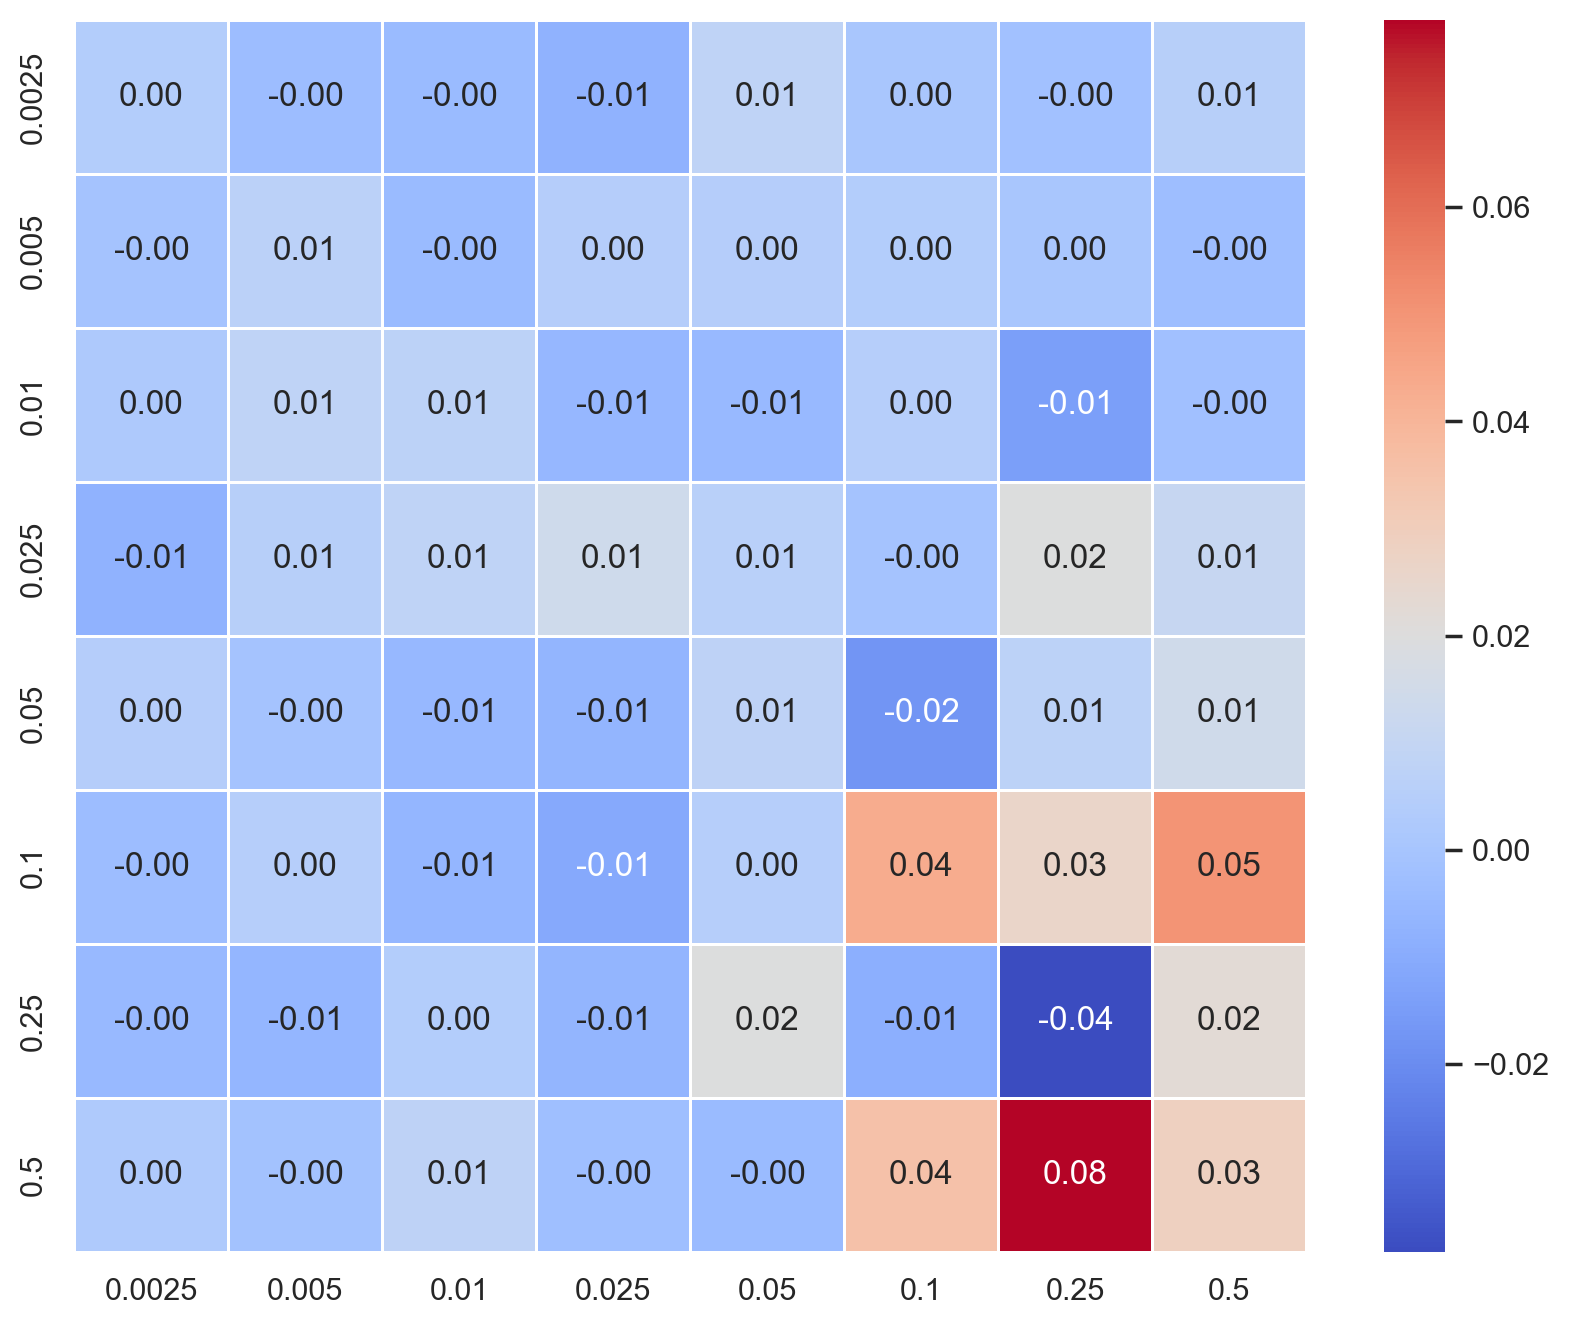

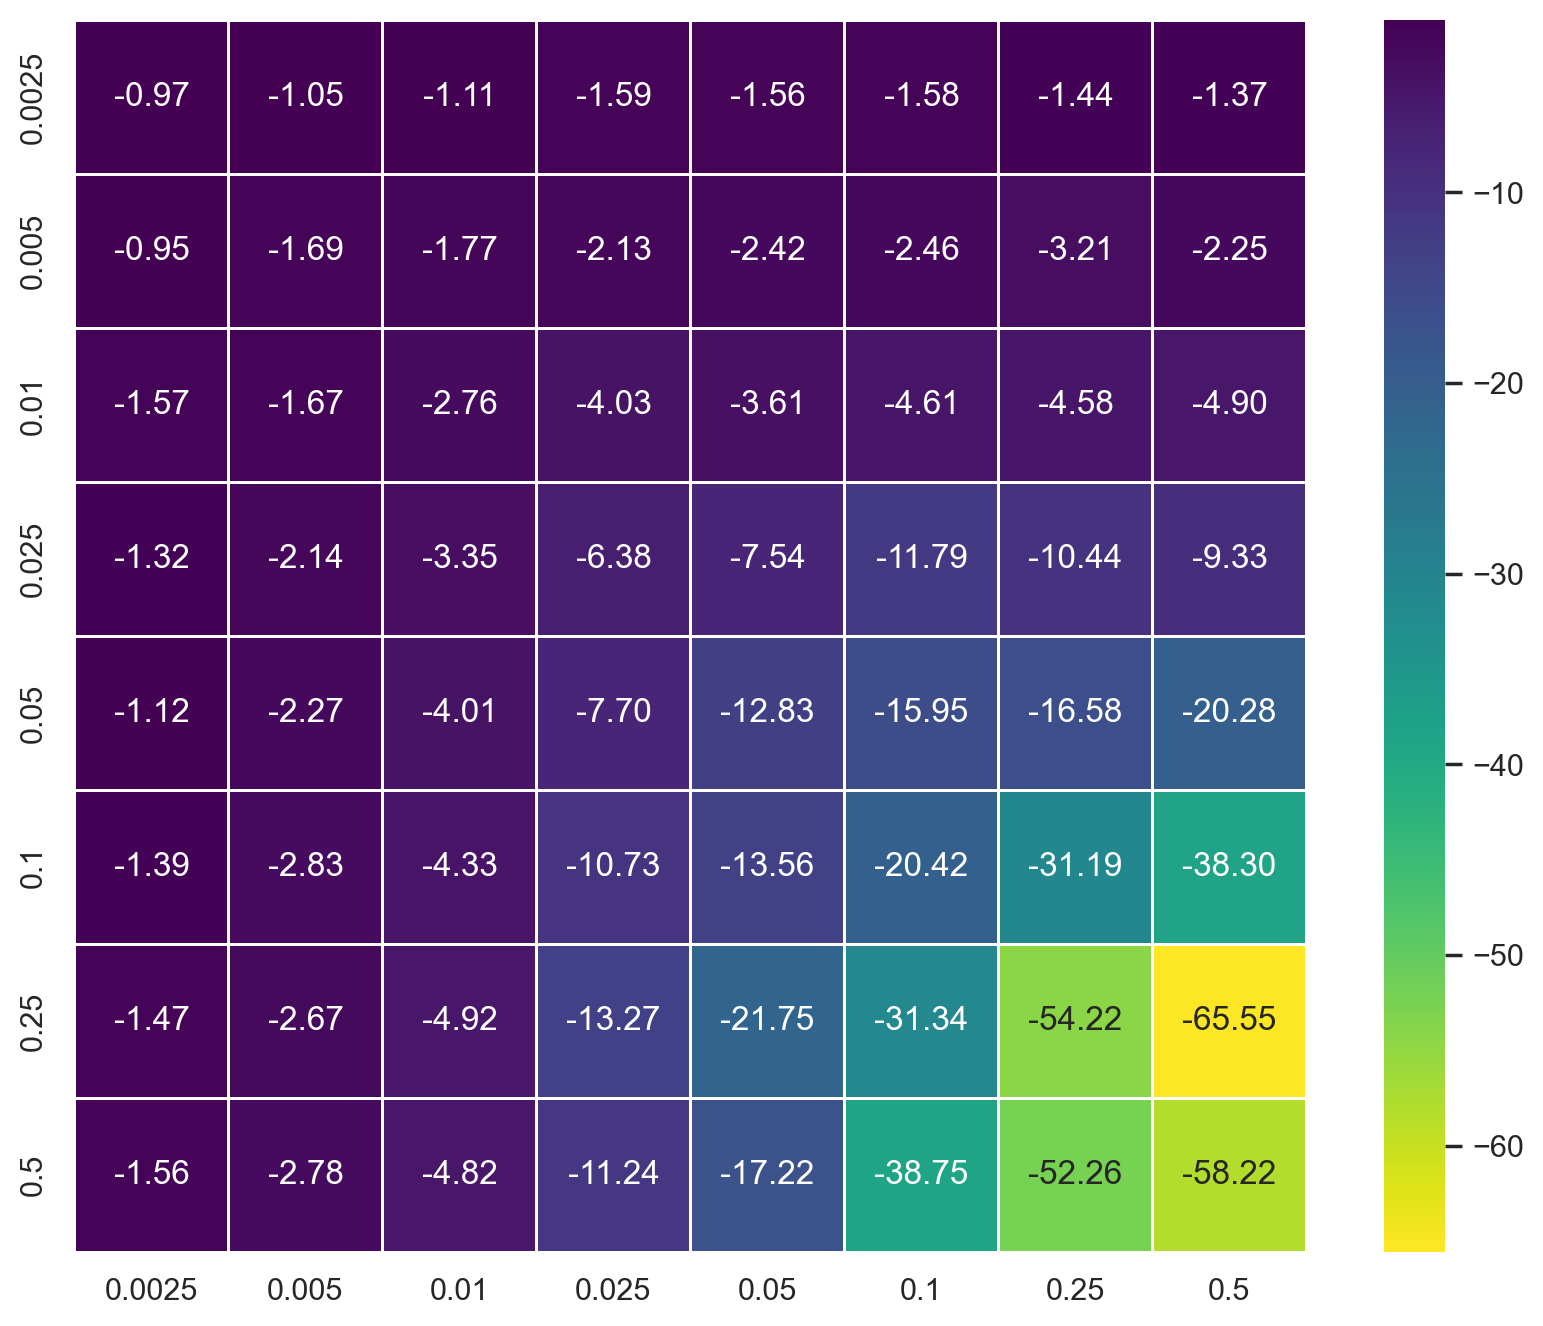

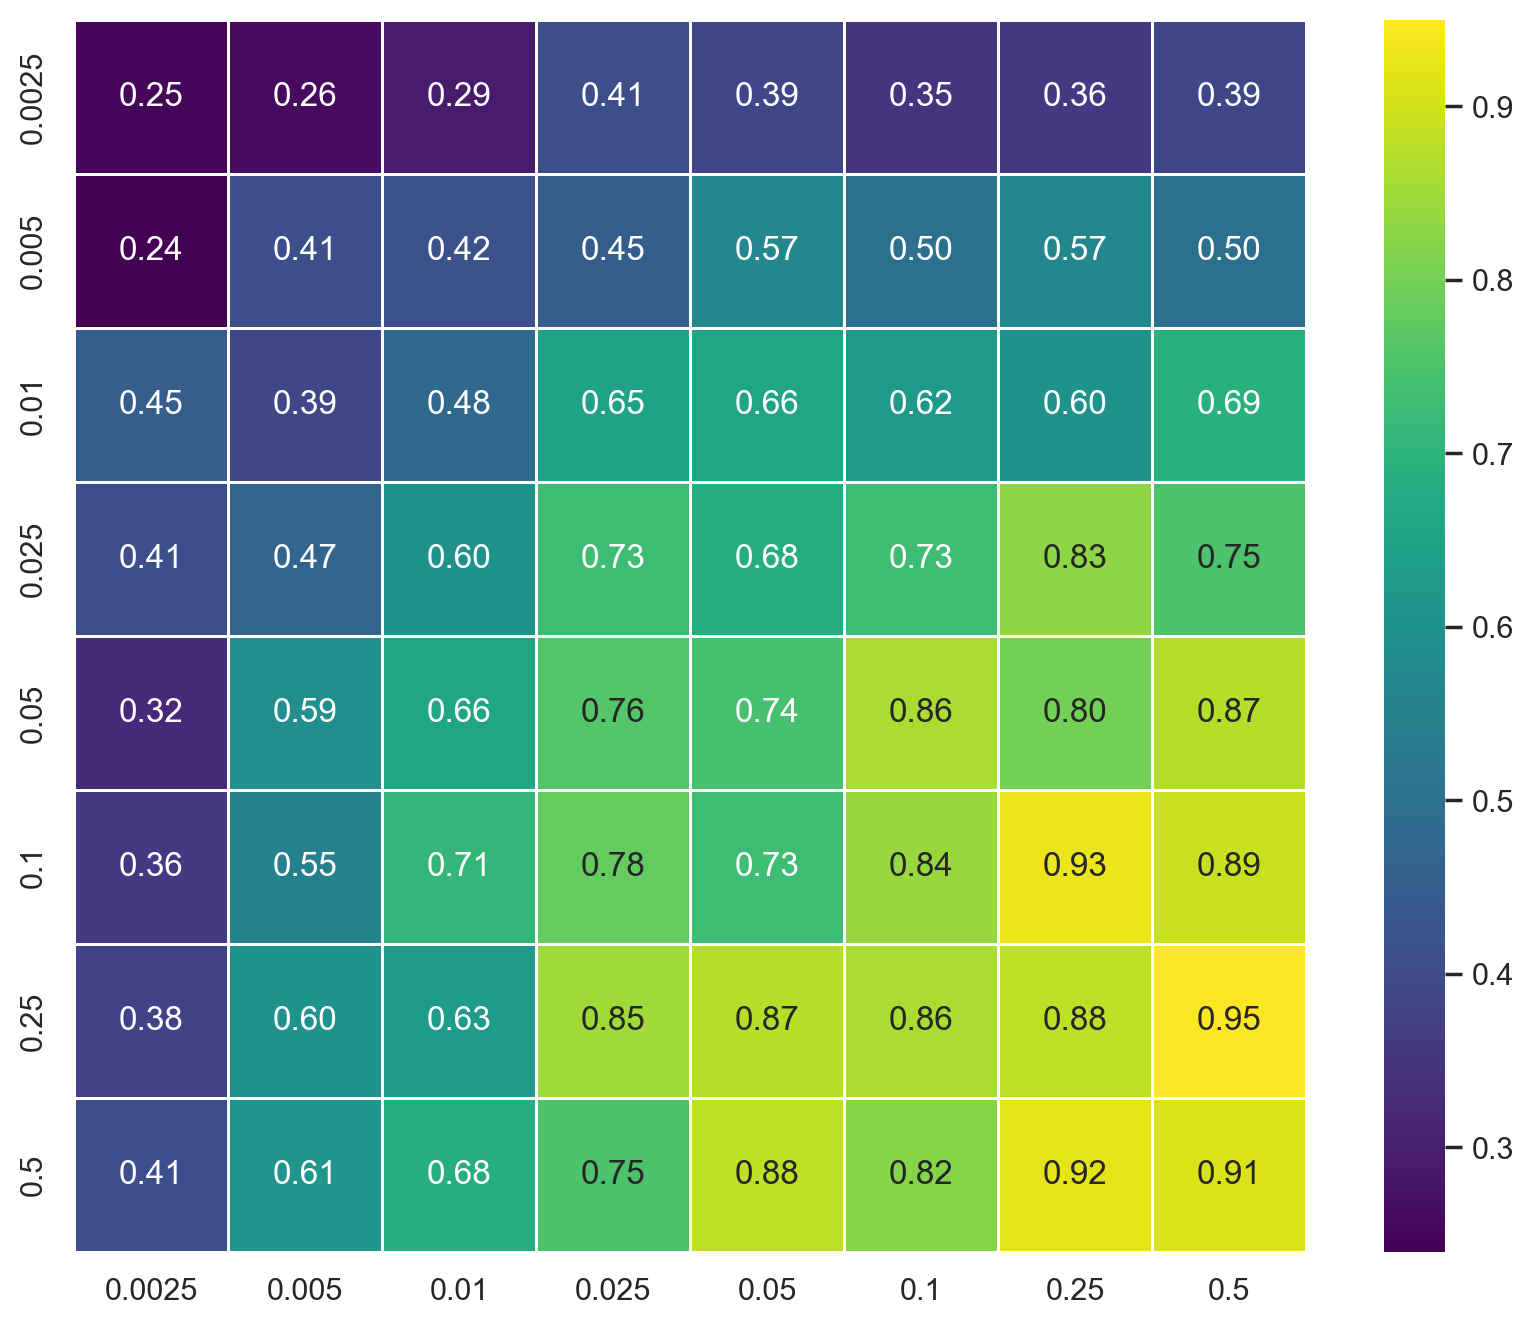

In [34]:
sns.set_theme(rc={'figure.figsize':(10,8)})
sns.set_style('whitegrid')
sns.set_style("whitegrid", {'axes.grid' : False})

# plot r_vals
sns.heatmap(avg_r*10, linewidth=0.5, square=True, cmap='coolwarm', annot=True, fmt=".2f", xticklabels=taus, yticklabels=taus)
plt.show()

# plot p_vals
sns.heatmap(avg_p, linewidth=0.5, square=True, cmap='viridis_r', annot=True, fmt=".2f", xticklabels=taus, yticklabels=taus)
plt.show()

# plot proportion of significant p-values
sns.heatmap(sig_counts, linewidth=0.5, square=True, cmap='viridis', annot=True, fmt=".2f", xticklabels=taus, yticklabels=taus)
plt.show()

In [47]:
# list of taus
taus = [0.0025, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5]

# number of simulation runs per combination
number_of_sims = 100

# filter settings
# delta, theta, alpha, beta, low gamma, high gamma
filter_range = [[1,4], [4,8], [8,12], [12,30], [30,60], [60,150]]
n_seconds_filter = 2.

# initialize
avg_coh = np.zeros((len(filter_range), len(taus), len(taus)))

for h in range(len(filter_range)):
    for i in range(len(taus)):
        for j in range(len(taus)):
            for k in range(number_of_sims):
                sim_regionA = sim_synaptic_current(n_seconds, fs, tau_d=taus[i])
                sim_regionB = sim_synaptic_current(n_seconds, fs, tau_d=taus[j])

                temp_coh = phase_phase_coherence(sim_regionA, sim_regionB, fs, filter_range[h], n_seconds_filter)

                avg_coh[h,i,j] = avg_coh[h,i,j] + temp_coh # running sum

    avg_coh[h, :, :] = avg_coh[h, :, :] / number_of_sims # get means

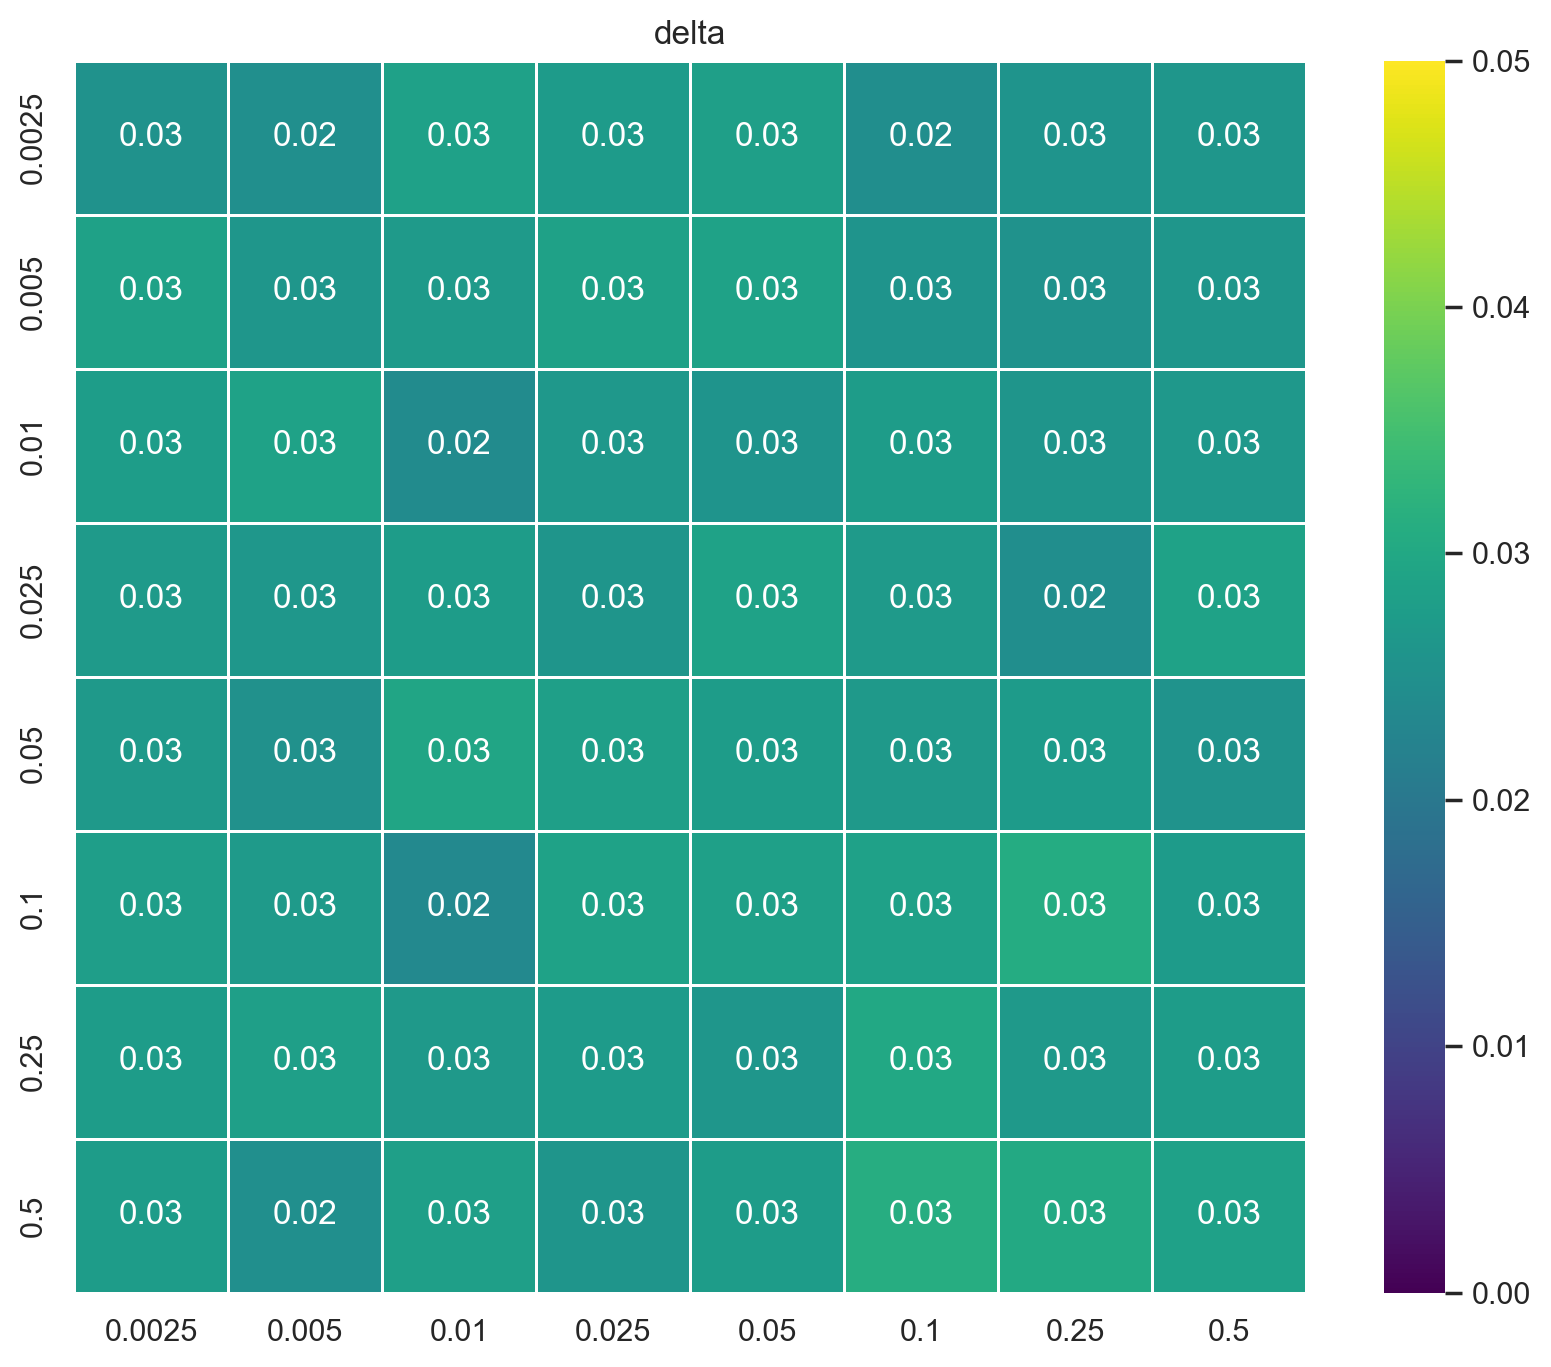

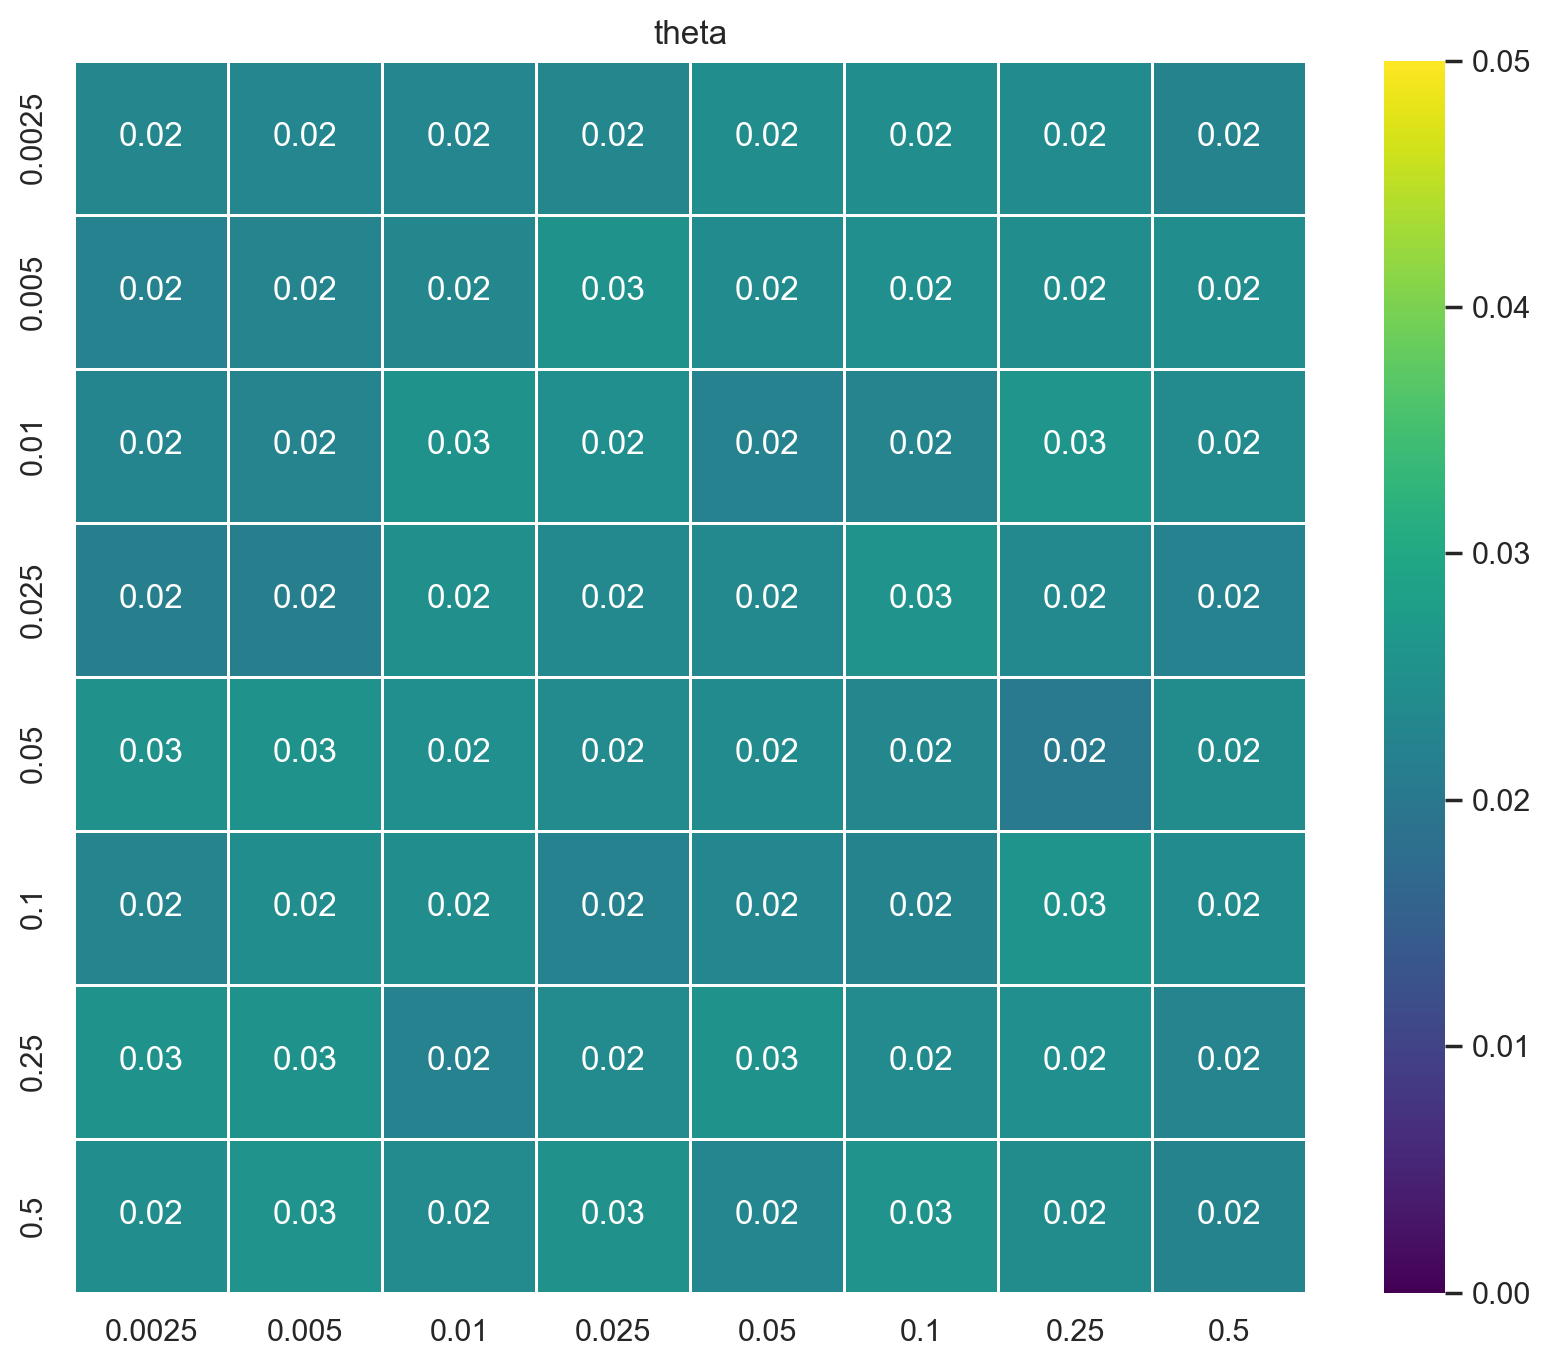

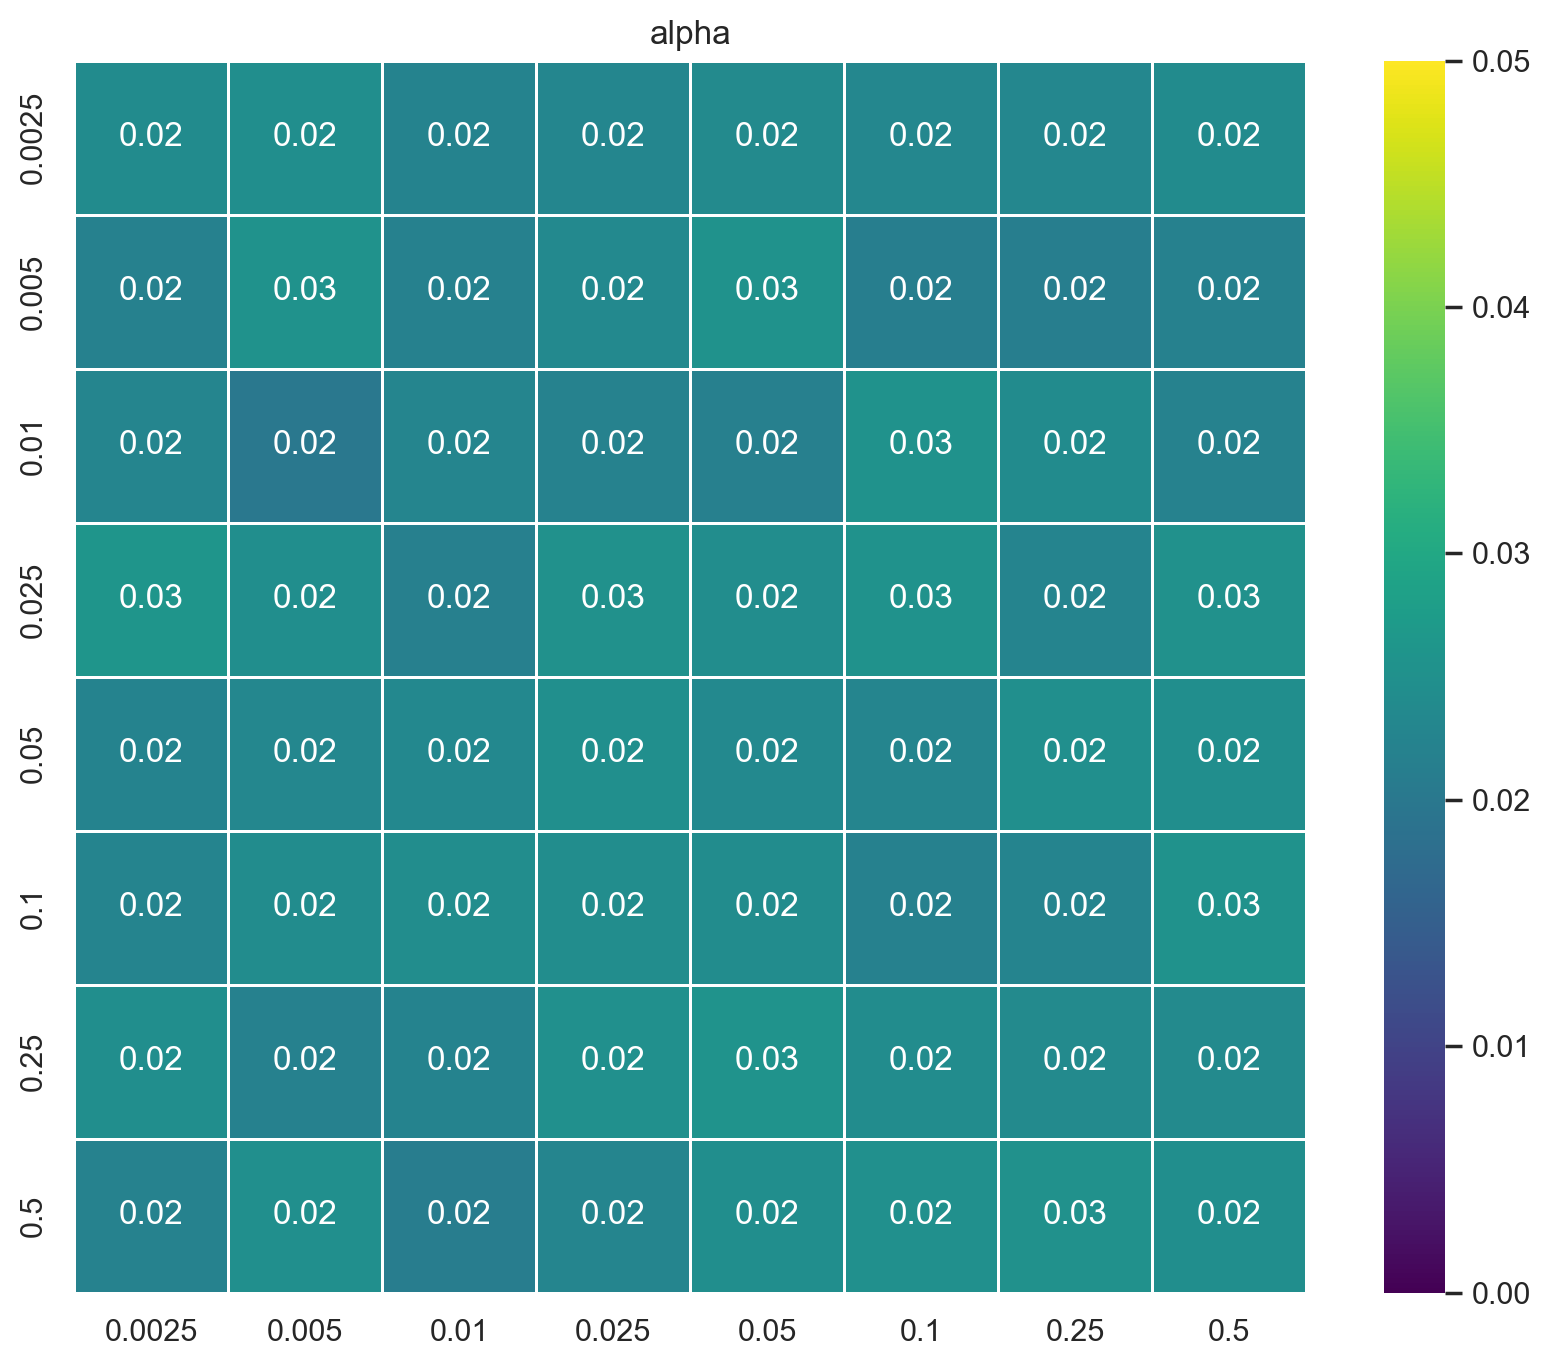

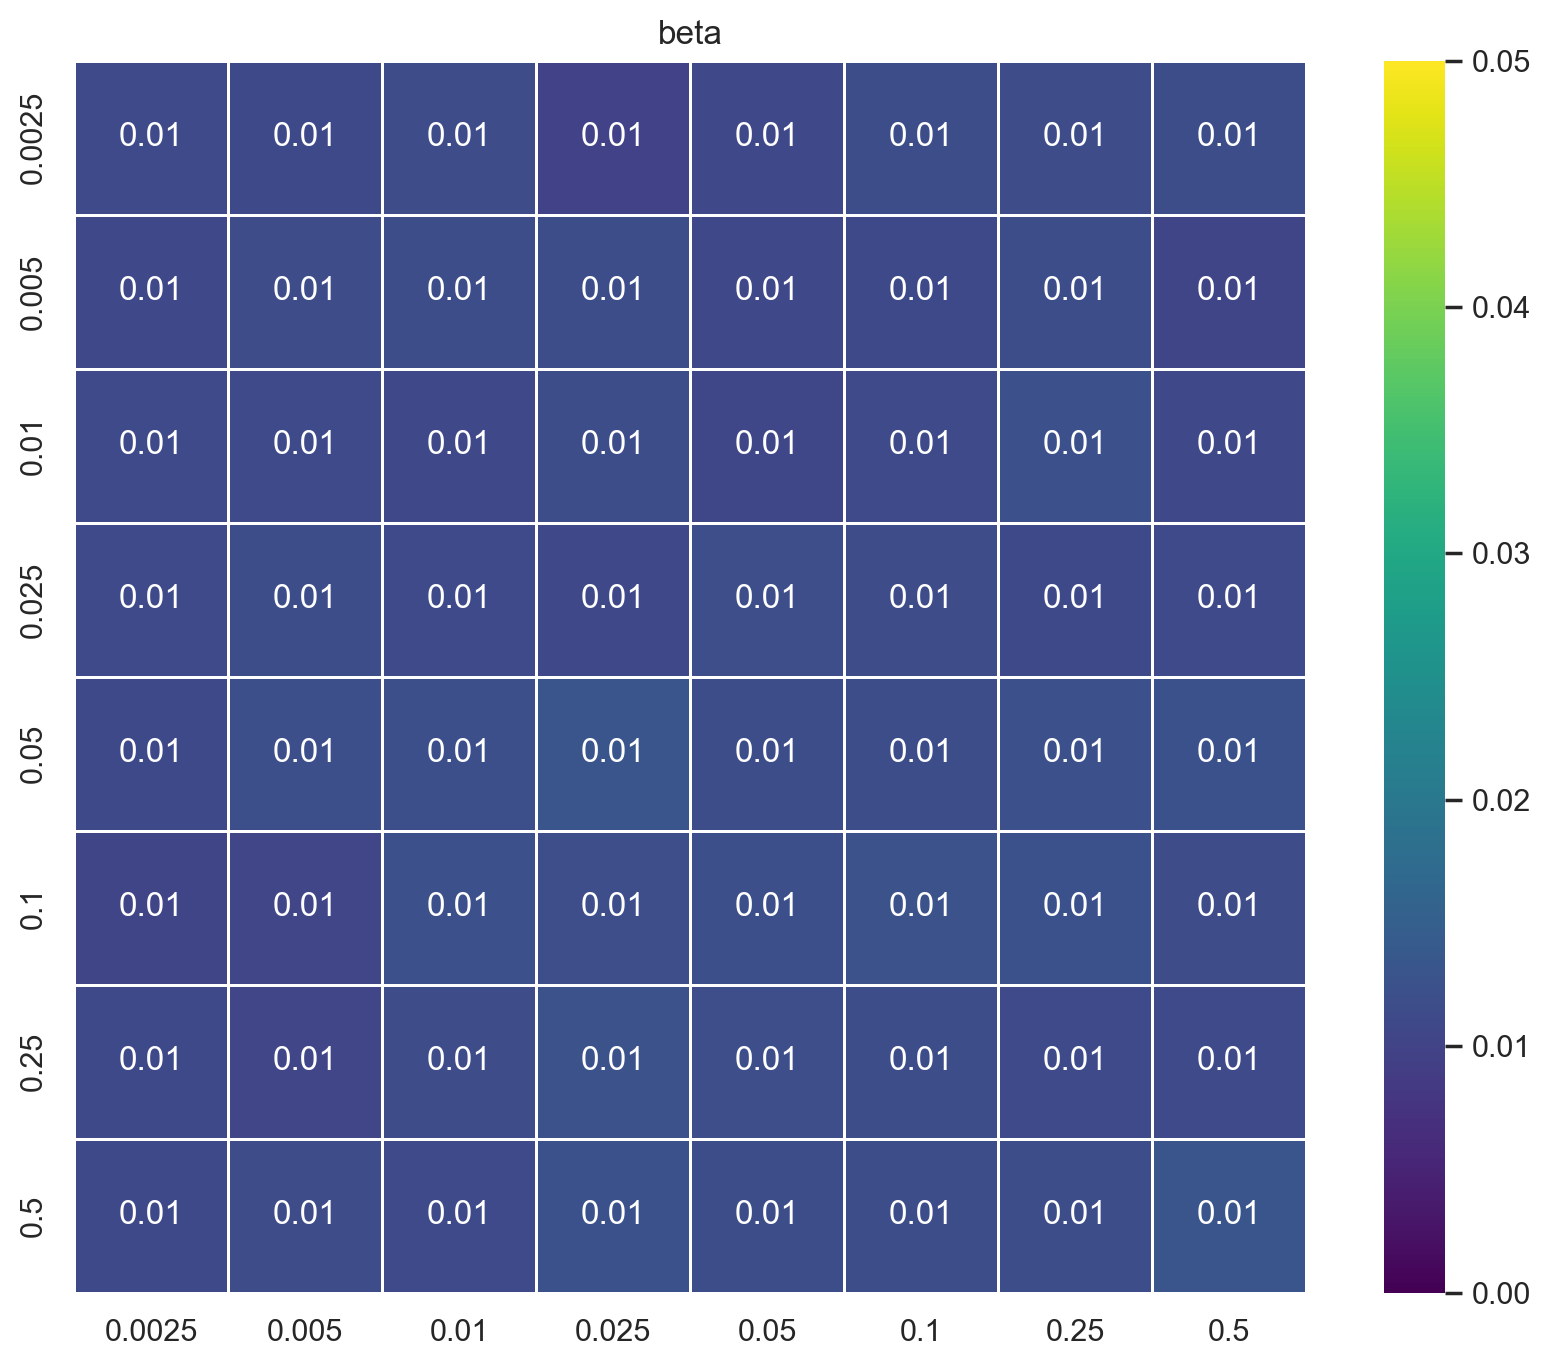

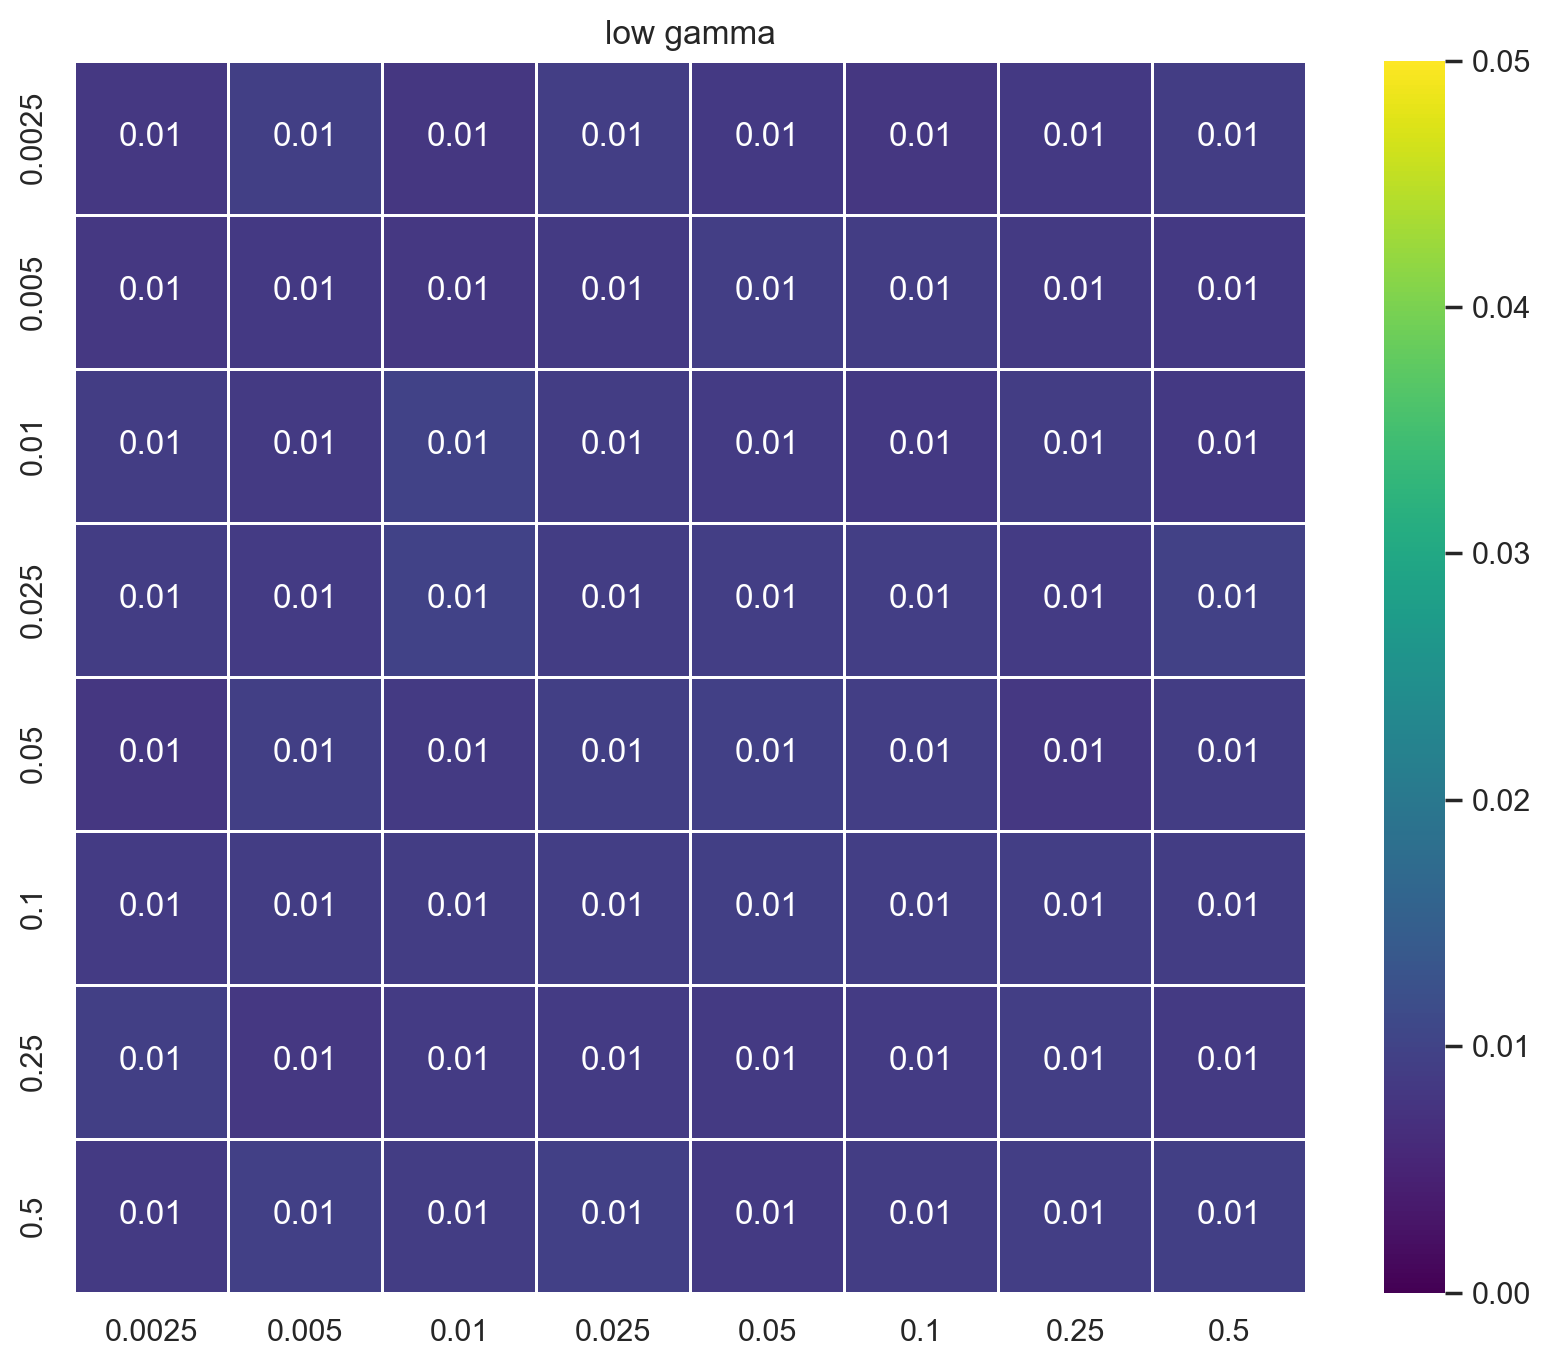

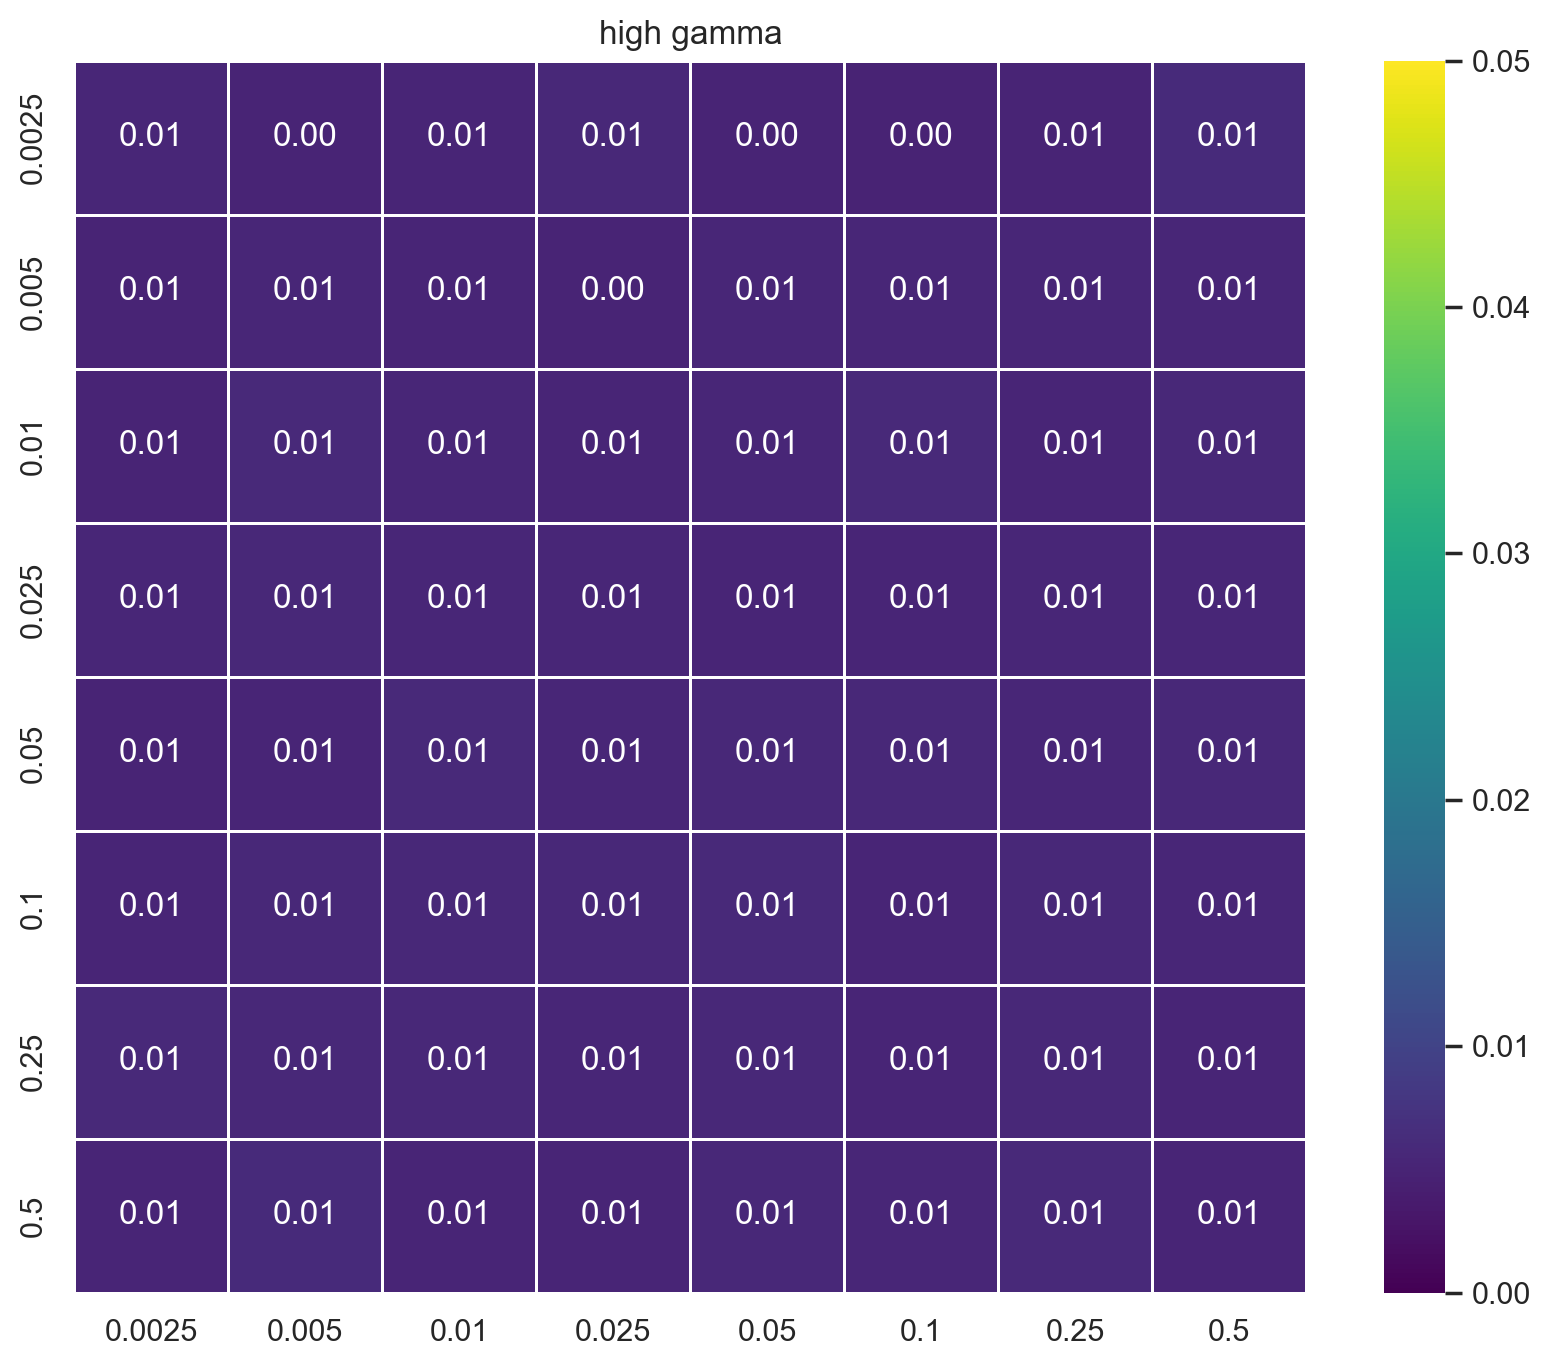

In [56]:
sns.set_theme(rc={'figure.figsize':(10,8)})
sns.set_style('whitegrid')
sns.set_style("whitegrid", {'axes.grid' : False})

# delta
sns.heatmap(avg_coh[0, :, :], linewidth=0.5, square=True, cmap='viridis', annot=True, fmt=".2f",
            xticklabels=taus, yticklabels=taus, vmin=0., vmax=0.05)
plt.title('delta')
plt.show()

# theta
sns.heatmap(avg_coh[1, :, :], linewidth=0.5, square=True, cmap='viridis', annot=True, fmt=".2f",
            xticklabels=taus, yticklabels=taus, vmin=0., vmax=0.05)
plt.title('theta')
plt.show()

# alpha
sns.heatmap(avg_coh[2, :, :], linewidth=0.5, square=True, cmap='viridis', annot=True, fmt=".2f",
            xticklabels=taus, yticklabels=taus, vmin=0., vmax=0.05)
plt.title('alpha')
plt.show()

# beta
sns.heatmap(avg_coh[3, :, :], linewidth=0.5, square=True, cmap='viridis', annot=True, fmt=".2f",
            xticklabels=taus, yticklabels=taus, vmin=0., vmax=0.05)
plt.title('beta')
plt.show()

# low gamma
sns.heatmap(avg_coh[4, :, :], linewidth=0.5, square=True, cmap='viridis', annot=True, fmt=".2f",
            xticklabels=taus, yticklabels=taus, vmin=0., vmax=0.05)
plt.title('low gamma')
plt.show()

# high gamma
sns.heatmap(avg_coh[5, :, :], linewidth=0.5, square=True, cmap='viridis', annot=True, fmt=".2f",
            xticklabels=taus, yticklabels=taus, vmin=0., vmax=0.05)
plt.title('high gamma')
plt.show()